In [59]:
import os
import logging
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, f1_score, recall_score, 
    roc_curve, auc, ConfusionMatrixDisplay, mean_squared_error, r2_score
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from ydata_profiling import ProfileReport
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [60]:
class BikeDemandDataProcessor:
    def __init__(self, path):
        self.path = path

    def load_data(self, filename):
        full_path = f"{self.path}/{filename}"
        print(f"Loading data from {full_path}")
        try:
            return pd.read_csv(full_path)
        except FileNotFoundError:
            print(f"File {filename} not found in path {self.path}.")
            return None

    def preprocess(self, df):

        df = df.copy()
        df['timestamp'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str) + ':00:00', format='%d/%m/%Y %H:%M:%S')
        df.rename(columns={'hr': 'hour', 'yr' : 'year', 'mnth' : 'month', 'cnt' : 'count'}, inplace=True)
        df.drop(['dteday', 'instant'], axis=1, inplace=True)



        df['payday'] = df['timestamp'].dt.is_month_end.astype(int)


        df['year'] = df['timestamp'].dt.year
        df['day'] = df['timestamp'].dt.day
        df['weekday'] = df['timestamp'].dt.weekday
        df['month'] = df['timestamp'].dt.month
        df['week'] = df['timestamp'].dt.isocalendar().week
        df['year_sin'] = np.sin(2 * np.pi * df['year'])
        df['year_cos'] = np.cos(2 * np.pi * df['year'])
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) 
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['working_day'] = df['weekday'].apply(lambda x: 1 if x < 5 else 0)
        df['weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
        df['quarter'] = df['timestamp'].dt.quarter
        df['week'] = df['timestamp'].dt.isocalendar().week
        df['moonphase'] = df['timestamp'].apply(lambda x: (x.day + x.month * 29.53) % 29.53)

        df['rush_hour'] = df.apply(lambda x: 1 if ((x['hour'] >= 6 and x['hour'] <= 10) or (x['hour'] >= 15 and x['hour'] <= 20)) and x['working_day'] == 1 else 0, axis=1)

        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].astype('category')

        return df
    
    def feature_engineering(self, train_df, val_df):
        train_df = train_df.copy()
        val_df = val_df.copy()

        # Avoid division by zero
        casual_sum = train_df['casual'].sum()
        if casual_sum == 0:
            casual_sum = 1  # Prevent division by zero

        total_ratio_of_registered_uses = train_df['registered'].sum() / casual_sum

        average_hour_ratio = train_df.groupby('hour').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_day_ratio = train_df.groupby('weekday').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_week_ratio = train_df.groupby('week').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_month_ratio = train_df.groupby('month').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_season_ratio = train_df.groupby('season').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))

        train_df['total_registered_ratio'] = total_ratio_of_registered_uses
        val_df['total_registered_ratio'] = total_ratio_of_registered_uses

        train_df['hour_ratio'] = train_df['hour'].map(average_hour_ratio)
        val_df['hour_ratio'] = val_df['hour'].map(average_hour_ratio)

        train_df['day_ratio'] = train_df['weekday'].map(average_day_ratio)
        val_df['day_ratio'] = val_df['weekday'].map(average_day_ratio)

        train_df['week_ratio'] = train_df['week'].map(average_week_ratio)
        val_df['week_ratio'] = val_df['week'].map(average_week_ratio)

        train_df['month_ratio'] = train_df['month'].map(average_month_ratio)
        val_df['month_ratio'] = val_df['month'].map(average_month_ratio)

        train_df['season_ratio'] = train_df['season'].map(average_season_ratio)
        val_df['season_ratio'] = val_df['season'].map(average_season_ratio)

        train_df.drop(['casual', 'registered'], axis=1, inplace=True)
        val_df.drop(['casual', 'registered'], axis=1, inplace=True)

        return train_df, val_df
    
    def split_and_engineer_data(self, df):
        sorted_df = df.sort_values('timestamp').copy()
        sorted_df.drop('timestamp', axis=1, inplace=True)

        train_df, val_df = train_test_split(sorted_df, test_size=0.2, shuffle=False)

        train_df, val_df = self.feature_engineering(train_df, val_df)

        return train_df, val_df

# Data Loading

In [61]:
parent_path = Path().resolve()
processor = BikeDemandDataProcessor(parent_path)

In [62]:
parent_path

PosixPath('/Users/lawrence/Documents/PYTHON/saga_tech_test_2025')

In [63]:
hour_raw_df = processor.load_data("hour.csv")

Loading data from /Users/lawrence/Documents/PYTHON/saga_tech_test_2025/hour.csv


In [64]:
hour_raw_df.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01/01/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,01/01/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,01/01/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,01/01/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,01/01/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [65]:
hour_processed_df = processor.preprocess(hour_raw_df)

In [66]:
hour_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   season       17379 non-null  int64         
 1   year         17379 non-null  int32         
 2   month        17379 non-null  int32         
 3   hour         17379 non-null  int64         
 4   holiday      17379 non-null  int64         
 5   weekday      17379 non-null  int32         
 6   workingday   17379 non-null  int64         
 7   weathersit   17379 non-null  int64         
 8   temp         17379 non-null  float64       
 9   atemp        17379 non-null  float64       
 10  hum          17379 non-null  float64       
 11  windspeed    17379 non-null  float64       
 12  casual       17379 non-null  int64         
 13  registered   17379 non-null  int64         
 14  count        17379 non-null  int64         
 15  timestamp    17379 non-null  datetime64[ns]
 16  payd

In [67]:
hour_processed_df.head()

,season,year,month,hour,holiday,weekday,workingday,weathersit,temp,atemp,...,month_cos,day_sin,day_cos,hour_sin,hour_cos,working_day,weekend,quarter,moonphase,rush_hour
0,1,2011,1,0,0,5,0,1,0.24,0.2879,...,0.866025,0.201299,0.97953,0.000000,1.000000,0,1,1,1.0,0
1,1,2011,1,1,0,5,0,1,0.22,0.2727,...,0.866025,0.201299,0.97953,0.258819,0.965926,0,1,1,1.0,0
2,1,2011,1,2,0,5,0,1,0.22,0.2727,...,0.866025,0.201299,0.97953,0.500000,0.866025,0,1,1,1.0,0
3,1,2011,1,3,0,5,0,1,0.24,0.2879,...,0.866025,0.201299,0.97953,0.707107,0.707107,0,1,1,1.0,0
4,1,2011,1,4,0,5,0,1,0.24,0.2879,...,0.866025,0.201299,0.97953,0.866025,0.500000,0,1,1,1.0,0


In [68]:
null_counts = hour_processed_df.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


In [69]:
# Display the first few rows of the relevant columns to check alignment
hour_processed_df[['day', 'weekday', 'workingday', 'weekend']].drop_duplicates().head(10)

,day,weekday,workingday,weekend
0,1,5,0,1
24,2,6,0,1
47,3,0,1,0
69,4,1,1,0
92,5,2,1,0
115,6,3,1,0
138,7,4,1,0
161,8,5,0,1
185,9,6,0,1
209,10,0,1,0


In [70]:
missing_hours = hour_processed_df.set_index('timestamp').groupby([hour_processed_df['timestamp'].dt.date]).apply(lambda x: x['hour'].nunique() != 24)

missing_days = missing_hours[missing_hours].index
print(f"Days with missing hours: {missing_days}")

Days with missing hours: Index([], dtype='object', name='timestamp')


## Dataset Characteristics

Both `hour.csv` and `day.csv` have the following fields, except `hr` which is not available in `day.csv`:

- **instant**: record index
- **dteday**: date
- **season**: season (1: spring, 2: summer, 3: fall, 4: winter)
- **yr**: year (0: 2011, 1: 2012)
- **mnth**: month (1 to 12)
- **hr**: hour (0 to 23)
- **holiday**: whether the day is a holiday or not
- **weekday**: day of the week
- **workingday**: if the day is neither weekend nor holiday is 1, otherwise is 0
- **weathersit**:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp**: Normalized temperature in Celsius. The values are divided by 41 (max)
- **atemp**: Normalized feeling temperature in Celsius. The values are divided by 50 (max)
- **hum**: Normalized humidity. The values are divided by 100 (max)
- **windspeed**: Normalized wind speed. The values are divided by 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered
```

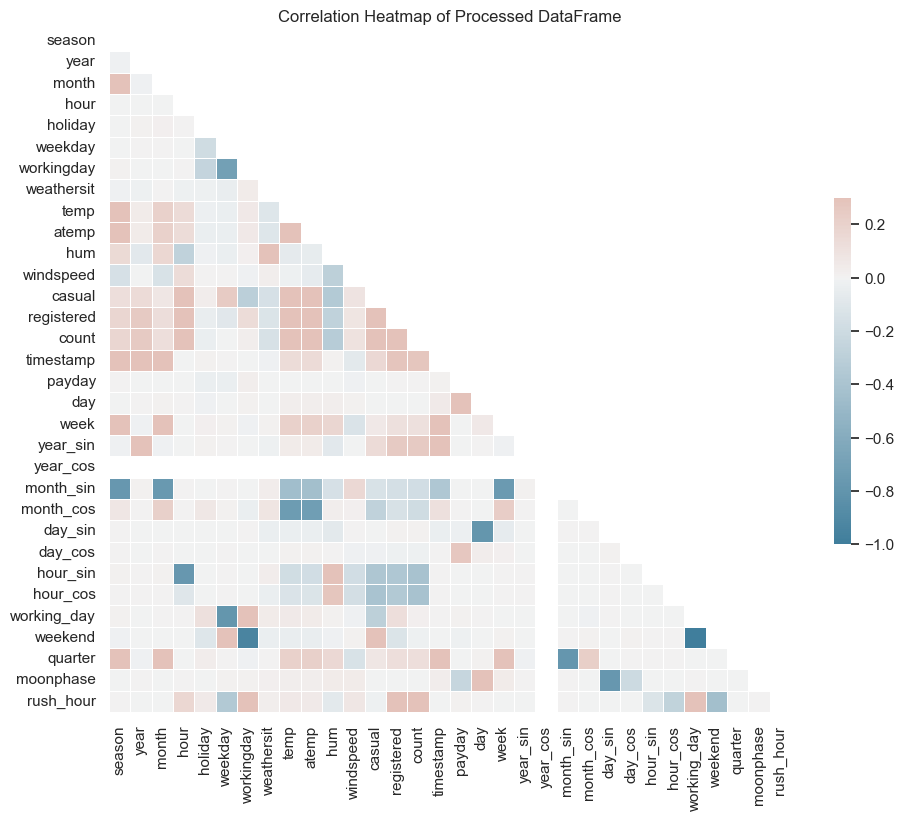

In [71]:
hour_processed_df_numeric = hour_processed_df.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

sns.set_theme(style="white")

corr = hour_processed_df_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Processed DataFrame')
plt.show()

In [72]:
# hour_processed_df_profile = ProfileReport(hour_processed_df, title="Pandas Profiling Report for hour_processed_df")
# hour_processed_df_profile.to_notebook_iframe()

In [73]:
train_df, val_df = processor.split_and_engineer_data(hour_processed_df)

/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_45464/515311390.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_hour_ratio = train_df.groupby('hour').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_45464/515311390.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_day_ratio = train_df.groupby('week

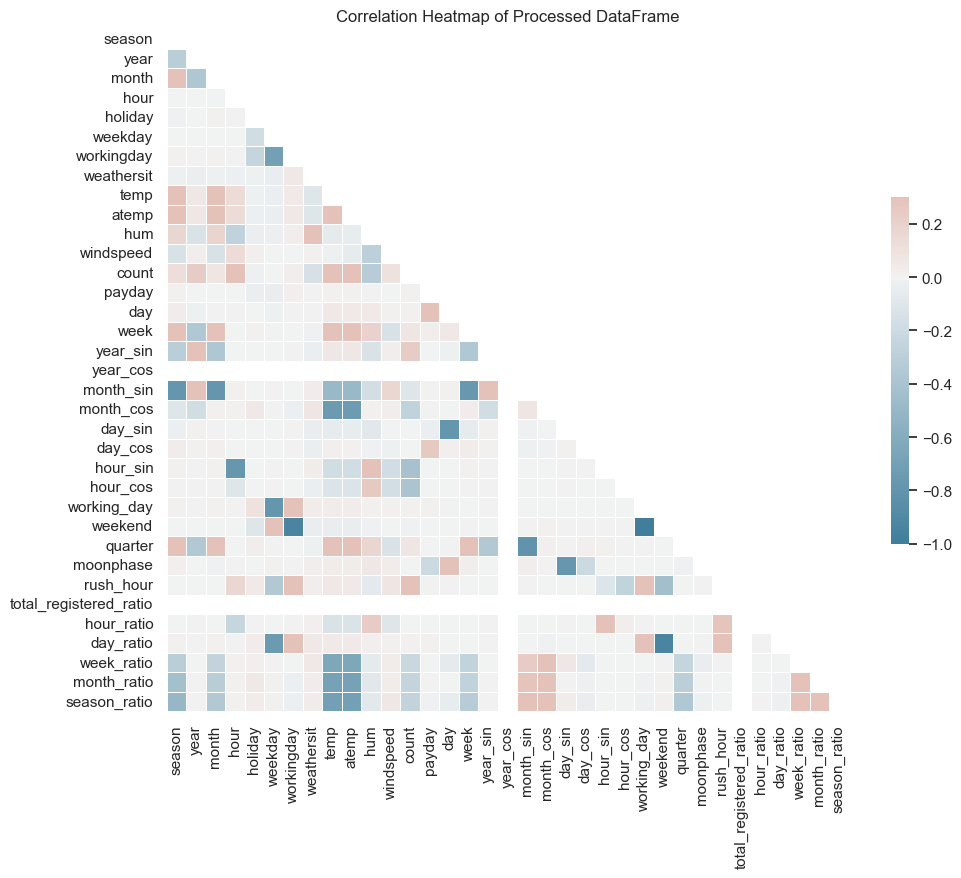

In [74]:
train_df_numeric = train_df.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

sns.set_theme(style="white")

corr = train_df_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Processed DataFrame')
plt.show()

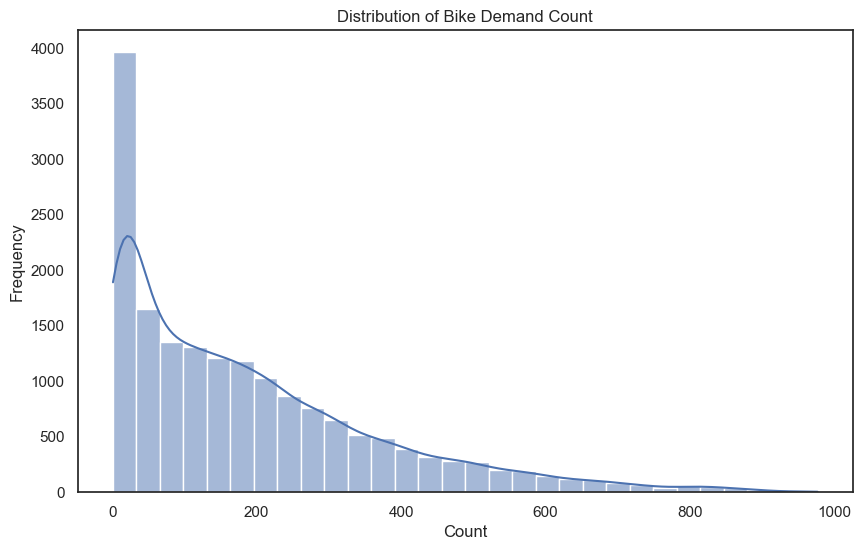

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(hour_processed_df['count'], bins=30, kde=True)
plt.title('Distribution of Bike Demand Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

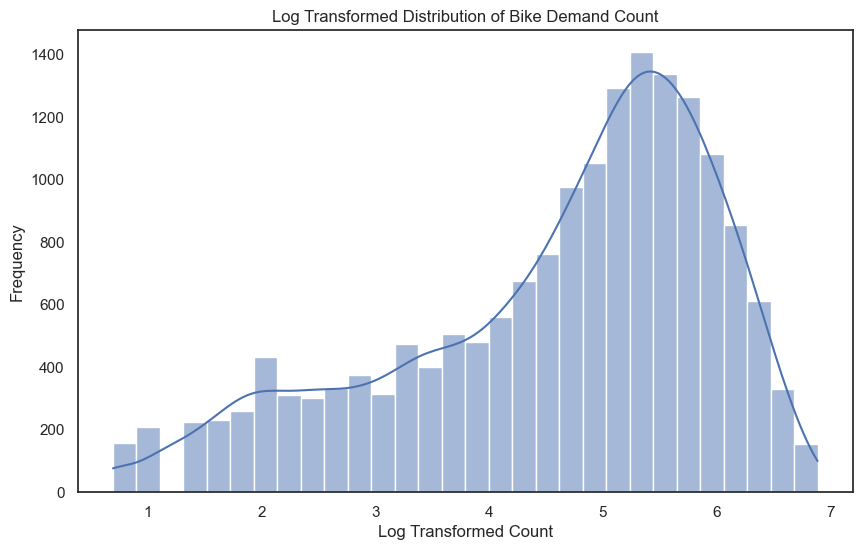

In [76]:
# Apply log transformation
count_log = np.log1p(hour_processed_df['count'])  # Use log1p to handle zero values

plt.figure(figsize=(10, 6))
sns.histplot(count_log, bins=30, kde=True)
plt.title('Log Transformed Distribution of Bike Demand Count')
plt.xlabel('Log Transformed Count')
plt.ylabel('Frequency')
plt.show()

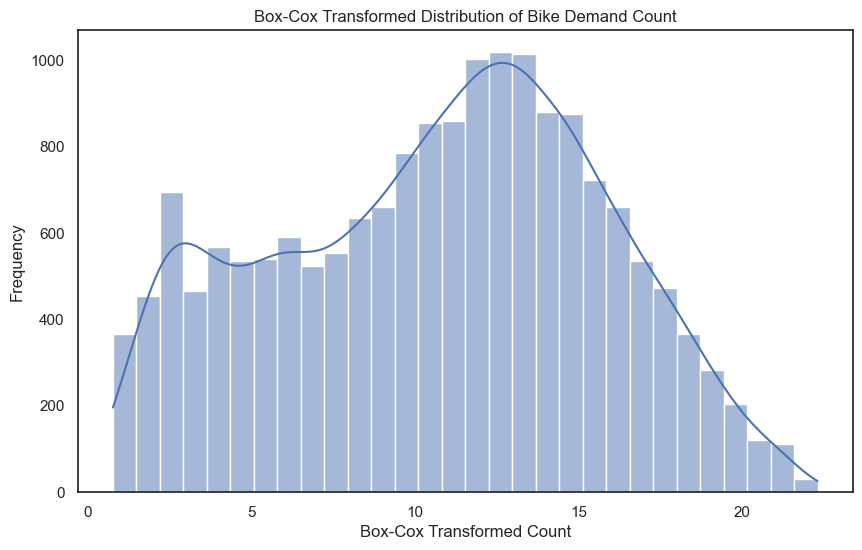

In [77]:
from scipy import stats

# Apply Box-Cox transformation
count_boxcox, _ = stats.boxcox(hour_processed_df['count'] + 1)  # Adding 1 to avoid zero values

plt.figure(figsize=(10, 6))
sns.histplot(count_boxcox, bins=30, kde=True)
plt.title('Box-Cox Transformed Distribution of Bike Demand Count')
plt.xlabel('Box-Cox Transformed Count')
plt.ylabel('Frequency')
plt.show()

In [78]:
# Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, StackingClassifier, StackingRegressor

# Gradient Boosting Models
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBClassifier, XGBRegressor

In [79]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13903 entries, 0 to 13902
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season                  13903 non-null  int64  
 1   year                    13903 non-null  int32  
 2   month                   13903 non-null  int32  
 3   hour                    13903 non-null  int64  
 4   holiday                 13903 non-null  int64  
 5   weekday                 13903 non-null  int32  
 6   workingday              13903 non-null  int64  
 7   weathersit              13903 non-null  int64  
 8   temp                    13903 non-null  float64
 9   atemp                   13903 non-null  float64
 10  hum                     13903 non-null  float64
 11  windspeed               13903 non-null  float64
 12  count                   13903 non-null  int64  
 13  payday                  13903 non-null  int64  
 14  day                     13903 non-null  int

In [80]:
train_df.columns

Index(['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'count', 'payday',
       'day', 'week', 'year_sin', 'year_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'working_day', 'weekend',
       'quarter', 'moonphase', 'rush_hour', 'total_registered_ratio',
       'hour_ratio', 'day_ratio', 'week_ratio', 'month_ratio', 'season_ratio'],
      dtype='object')

In [81]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

target = 'count'

# Define columns
numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'year_sin', 'year_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'moonphase', 'total_registered_ratio', 'hour_ratio', 'day_ratio', 'week_ratio', 'month_ratio', 'season_ratio']
categorical_columns = ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weathersit', 'payday', 'day', 'week', 'working_day', 'weekend', 'quarter', 'rush_hour']

# Define transformers
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), 
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, categorical_columns),
    ],
    remainder='passthrough',
    n_jobs=-1
)

reg1 = Pipeline([
    ("preprocessor", preprocessor), 
    ("regressor", lgb.LGBMRegressor(
        verbosity=-1, 
        # device="gpu"
    ))
])

features = numeric_columns + categorical_columns


In [82]:
reg1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed', 'year_sin',
                                                   'year_cos', 'month_sin',
                                                   'month_cos', 'day_sin',
                                                   'day_cos', 'hour_sin',
                                                   'hour_cos', 'moonphase',
                                                   'total_registered_ratio',
                                                   'hour_ratio', 'day_ratio',
                                                   'week_ratio', 'month_ratio',
                                                   'season_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['season', 'year', 'month',
                                                   'hour', 'holiday', 'weekday',
                                                   'workingday', 'weathersit',
                                                   'payday', 'day', 'week',
                                                   'working_day', 'weekend',
                                                   'quarter', 'rush_hour'])])),
                ('regressor', LGBMRegressor(verbosity=-1))])

In [83]:
from scipy.stats import boxcox

def inv_boxcox(y, lambda_):
    """Inverse Box-Cox transformation"""
    return np.exp(np.log(lambda_ * y + 1) / lambda_) if lambda_ != 0 else np.expm1(y)

params = {
    'regressor__learning_rate': 0.01,
    'regressor__n_estimators': 1000,
    'regressor__num_leaves': 31,
    'regressor__boosting_type': 'gbdt',
    'regressor__max_depth': -1,
    'regressor__min_child_samples': 20,
    'regressor__max_bin': 255,
    'regressor__colsample_bytree': 0.8,
    'regressor__subsample': 0.8,
    'regressor__subsample_freq': 1,
    'regressor__reg_alpha': 0.1,
    'regressor__reg_lambda': 0.1,
    'regressor__objective': 'regression_l2',  # Use regression_l2 for RMSLE
    'regressor__metric': 'rmse'
}

X_train = train_df[features]
y_train, lambda_bc = boxcox(train_df[target] + 1)  # Add 1 to avoid zero values

reg1.set_params(**params)

reg1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed', 'year_sin',
                                                   'year_cos', 'month_sin',
                                                   'month_cos', 'day_sin',
                                                   'day_cos', 'hour_sin',
                                                   'hour_cos', 'moonphase',
                                                   'total_registered_ra...
                                                  ['season', 'year', 'month',
                                                   'hour', 'holiday', 'weekday',
                                                   'workingday', 'weathersit',
                                                   'payday', 'day', 'week',
                                                   'working_day', 'weekend',
                                                   'quarter', 'rush_hour'])])),
                ('regressor',
                 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01,
                               max_bin=255, metric='rmse', n_estimators=1000,
                               objective='regression_l2', reg_alpha=0.1,
                               reg_lambda=0.1, subsample=0.8, subsample_freq=1,
                               verbosity=-1))])

/Users/lawrence/Documents/PYTHON/saga_tech_test_2025/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RMSLE: 0.5768
MAE: 78.8816
RMSE: 125.5772


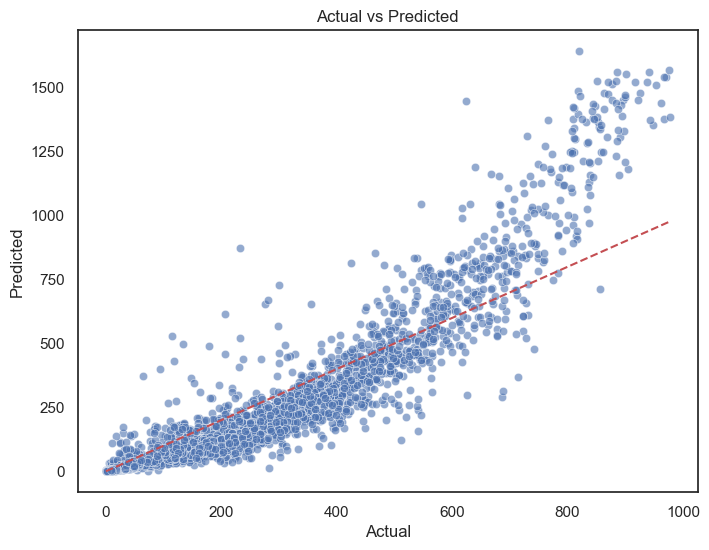

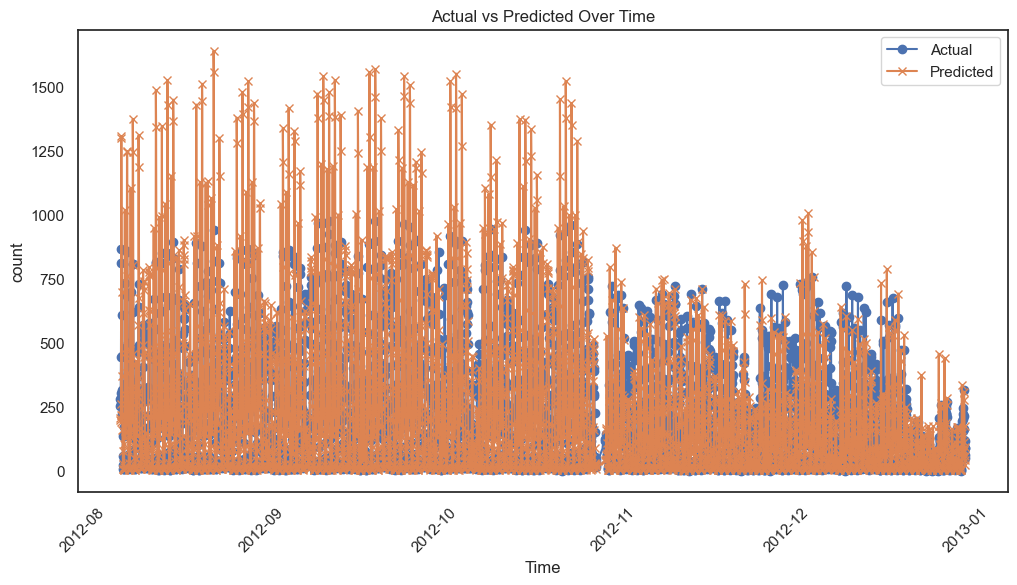

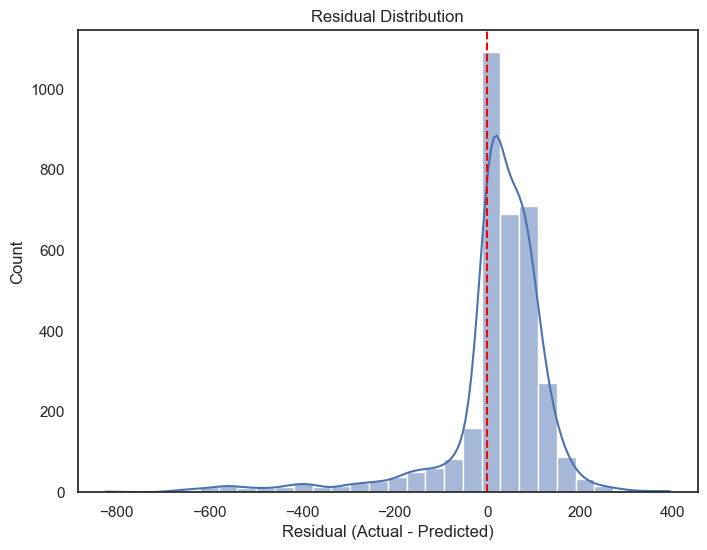

In [84]:
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error

def inv_boxcox(y, lambda_):
    """Inverse Box-Cox transformation"""
    return (np.exp(y * lambda_) - 1) / lambda_ if lambda_ != 0 else np.expm1(y)

params = {
    'regressor__learning_rate': 0.01,
    'regressor__n_estimators': 1000,
    'regressor__num_leaves': 31,
    'regressor__boosting_type': 'gbdt',
    'regressor__max_depth': -1,
    'regressor__min_child_samples': 20,
    'regressor__max_bin': 255,
    'regressor__colsample_bytree': 0.8,
    'regressor__subsample': 0.8,
    'regressor__subsample_freq': 1,
    'regressor__reg_alpha': 0.1,
    'regressor__reg_lambda': 0.1,
    'regressor__objective': 'regression_l2',  # Use regression_l2 for RMSLE
    'regressor__metric': 'rmse'
}

X_train = train_df[features]
y_train, lambda_bc = boxcox(train_df[target] + 1)  # Add 1 to avoid zero values

reg1.set_params(**params)

reg1.fit(X_train, y_train)

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))

X_val = val_df[features]
y_val_transformed, _ = boxcox(val_df[target] + 1)  # Add 1 to avoid zero values

y_pred_transformed = reg1.predict(X_val)
y_pred = inv_boxcox(y_pred_transformed, lambda_bc)

# Calculate metrics
rmsle_score = rmsle(val_df[target], y_pred)
mae = mean_absolute_error(val_df[target], y_pred)
mse = mean_squared_error(val_df[target], y_pred)
rmse = np.sqrt(mse)

# Print metrics
print(f"RMSLE: {rmsle_score:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=val_df[target], y=y_pred, alpha=0.6)
plt.plot([min(val_df[target]), max(val_df[target])], [min(val_df[target]), max(val_df[target])], '--r')  # Perfect predictions line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

# Line Plot: Time series comparison
val_df['timestamp'] = pd.to_datetime(val_df[['year', 'month', 'day', 'hour']])
plt.figure(figsize=(12, 6))
plt.plot(val_df['timestamp'], val_df[target], label="Actual", marker="o")
plt.plot(val_df['timestamp'], y_pred, label="Predicted", marker="x")
plt.xlabel("Time")
plt.ylabel(target)
plt.title("Actual vs Predicted Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Residual Plot: Prediction errors
residuals = val_df[target] - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution")
plt.show()